In [1]:
%time
import os
import keras
from keras.datasets import mnist
from kohonen_sup import TrnParams as Trn
from kohonen_sup import KohonenSup as KohonenClass

#from sklearn import datasets
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
from sklearn.metrics import accuracy_score


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 15 µs


Using Theano backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#training set
classes = np.unique(y_train)
n_samples = 220; #n_samples for each class

for i in range(len(classes)):
    x_train_i = x_train[y_train==i][0:n_samples]
    if (i==0):
        x_train_new = x_train_i
    else:
        x_train_new = np.concatenate((x_train_new, x_train_i), axis=0)

#labels training set
for i in range(len(classes)):
    y_train_i = y_train[y_train==i][0:n_samples]
    if (i==0):
        y_train_new = y_train_i
    else:
        y_train_new = np.concatenate((y_train_new, y_train_i), axis=0)
        
#test set
classes = np.unique(y_test)
n_samples_test = 20; #n_samples for each class

for i in range(len(classes)):
    x_test_i = x_test[y_test==i][0:n_samples_test]
    if (i==0):
        x_test_new = x_test_i
    else:
        x_test_new = np.concatenate((x_test_new, x_test_i), axis=0)

# labels test set
for i in range(len(classes)):
    y_test_i = y_test[y_test==i][0:n_samples_test]
    if (i==0):
        y_test_new = y_test_i
    else:
        y_test_new = np.concatenate((y_test_new, y_test_i), axis=0)

        
x_train = x_train_new
y_train = y_train_new
x_test = x_test_new
y_test = y_test_new


#normalization
x_train /= 255 
x_test /= 255

classes = np.unique(y_train);
num_classes = len(classes)

#convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(2200, 'train samples')
(200, 'test samples')


In [19]:
n_folds = 10

output_train=np.zeros((n_folds,2000))
output_test=np.zeros((n_folds,200))
accuracy_train=np.zeros((n_folds,))
accuracy_test=np.zeros((n_folds,))
best_accuracy = 0
for ifold in range(n_folds):
    
    data_train, data_test, trgt_train, trgt_test = train_test_split(x_train, y_train, test_size=0.0909)
    #print data_train.shape[0], 'train samples'
    #print data_test.shape[0], 'test samples'

    #train Supervised Kohonen Map
    trn_params = Trn.TrnParams()

    trn_params.learning_rate = 0.01
#     W0 = np.array([np.mean(data[trgt==0], axis=0), np.mean(data[trgt==1], axis=0), np.mean(data[trgt==2], axis=0),
#                   np.mean(data[trgt==3], axis=0), np.mean(data[trgt==4], axis=0), np.mean(data[trgt==5], axis=0),
#                   np.mean(data[trgt==6], axis=0), np.mean(data[trgt==7], axis=0), np.mean(data[trgt==8], axis=0),
#                   np.mean(data[trgt==9], axis=0)])
    #kohonen_obj = KohonenClass.KohonenSup(W0=W0)
    kohonen_obj = KohonenClass.KohonenSup()
    kohonen_obj.fit(data=data_train,trgt=trgt_train.astype(int),trn_params=trn_params)
    output_train[ifold] = kohonen_obj.predict(data=data_train)
    output_test[ifold] =  kohonen_obj.predict(data=data_test)
    
    accuracy_train[ifold] = accuracy_score(trgt_train, output_train[ifold])
    accuracy_test[ifold] = accuracy_score(trgt_test, output_test[ifold])
    if (accuracy_test[ifold] > best_accuracy):
        best_test_accuracy = accuracy_test[ifold]
        best_train_accuracy = accuracy_train[ifold]
        best_output_train = output_train[ifold]
        best_output_test = output_test[ifold]
        best_data_train = data_train
        best_data_test = data_test
        best_trgt_train = trgt_train
        best_trgt_test = trgt_test

print 'Best train accuracy:', best_train_accuracy
print 'Best test accuracy:', best_test_accuracy

 Best train accuracy: 0.7925
Best test accuracy: 0.82


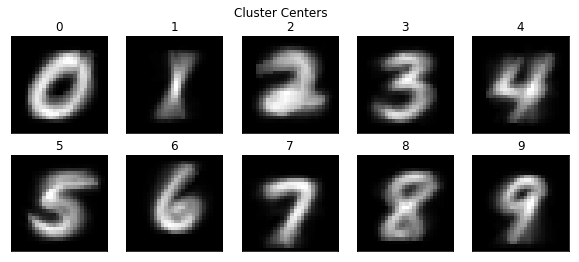

In [9]:
# plot cluster centers
output_train = best_output_train
data_train = best_data_train 
trgt_train = best_trgt_train

cluster_centers = kohonen_obj.clusters
n_clusters = np.shape(cluster_centers)[0]
most_freq = np.zeros(n_clusters)
freq = np.zeros([n_clusters, len(np.unique(trgt_train))])

for icluster in range(n_clusters):
    id_clusters = np.unique(output_train).astype(int)
    labels = trgt_train[output_train==id_clusters[icluster]]
    #print labels
    for iclass in range(len(np.unique(trgt_train))):
        freq[icluster,iclass]=np.sum(labels==iclass)
    
    most_freq[icluster] = np.argmax(np.bincount(labels))
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1

nrows = 2
ncols = 5
irow = 0
icolumn = 0
fig, ax = plt.subplots(figsize=(10,4),nrows=nrows, ncols=ncols)
plt.suptitle('Cluster Centers')

for cluster in range(np.shape(cluster_centers)[0]):
    img = cluster_centers[cluster];
    img = img.reshape(28,28);

    ax[irow,icolumn].imshow(img,cmap='gray',interpolation="nearest")
    ax[irow,icolumn].set_title(str(int(most_freq[cluster])))
    ax[irow,icolumn].get_xaxis().set_visible(False)
    ax[irow,icolumn].get_yaxis().set_visible(False)
    
    if (icolumn+1 == ncols):
        icolumn = 0
        irow = irow + 1
    else:
        icolumn = icolumn + 1
        
if cluster < (nrows*ncols):
    for i in range(cluster,nrows*ncols-1):
        ax[irow,icolumn].set_visible(False)
        
        if (icolumn+1 == ncols):
            icolumn = 0
            irow = irow + 1
        else:
            icolumn = icolumn + 1
            

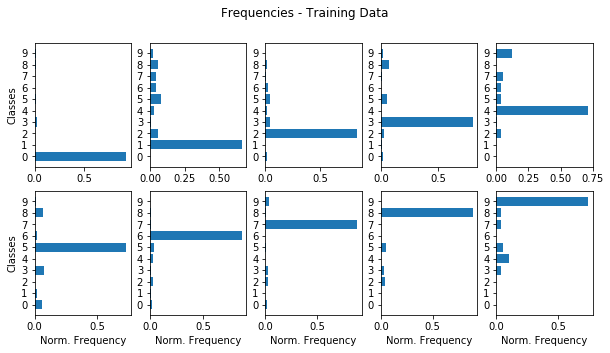

In [5]:
output_train = best_output_train
data_train = best_data_train 
trgt_train = best_trgt_train

#showing cluster frequencies - train data
cluster_centers = kohonen_obj.clusters
n_clusters = np.shape(cluster_centers)[0]
most_freq = np.zeros(n_clusters)
freq = np.zeros([n_clusters, len(np.unique(trgt_train))])

for icluster in range(n_clusters):
    id_clusters = np.unique(output_train).astype(int)
    labels = trgt_train[output_train==id_clusters[icluster]]
    
    for iclass in range(len(np.unique(trgt_train))):
        freq[icluster,iclass]=np.sum(labels==iclass)
    
    most_freq[icluster] = np.argmax(np.bincount(labels))
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1

nrows = 2
ncols = 5
irow = 0
icolumn = 0
fig, ax = plt.subplots(figsize=(10,5),nrows=nrows, ncols=ncols)
plt.suptitle('Frequencies - Training Data')
for cluster in range(np.shape(cluster_centers)[0]):
    val = freq[cluster,:]/np.sum(freq[cluster,:])
    pos = np.arange(len(np.unique(y_train)))
    
    ax[irow,icolumn].barh(pos,val, align='center')
    ax[irow,icolumn].get_yaxis().set_ticks(pos)
    if (irow==nrows-1):
        ax[irow,icolumn].set_xlabel('Norm. Frequency')
    if (icolumn==0):
        ax[irow,icolumn].set_ylabel('Classes')

    if (icolumn+1 == ncols):
        icolumn = 0
        irow = irow + 1
    else:
        icolumn = icolumn + 1

if cluster < (nrows*ncols):
    for i in range(cluster,nrows*ncols-1):
        ax[irow,icolumn].set_visible(False)
        
        if (icolumn+1 == ncols):
            icolumn = 0
            irow = irow + 1
        else:
            icolumn = icolumn + 1

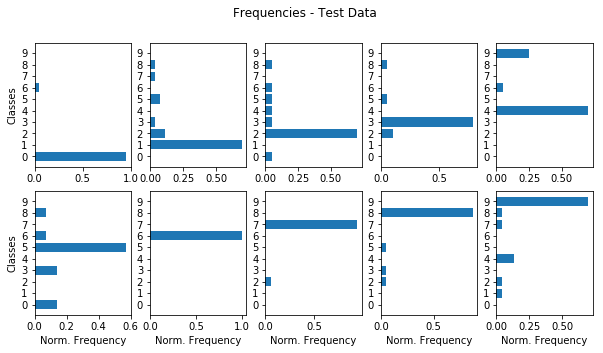

In [6]:
output_test = best_output_test
data_test = best_data_test
trgt_test = best_trgt_test

#showing cluster frequencies - test data
cluster_centers = kohonen_obj.clusters
n_clusters = np.shape(cluster_centers)[0]
most_freq = np.zeros(n_clusters)
freq = np.zeros([n_clusters, len(np.unique(trgt_test))])

for icluster in range(n_clusters):
    id_clusters = np.unique(output_test).astype(int)
    labels = trgt_test[output_test==id_clusters[icluster]]
    
    for iclass in range(len(np.unique(trgt_test))):
        freq[icluster,iclass]=np.sum(labels==iclass)
    
    most_freq[icluster] = np.argmax(np.bincount(labels))
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1

nrows = 2
ncols = 5
irow = 0
icolumn = 0
fig, ax = plt.subplots(figsize=(10,5),nrows=nrows, ncols=ncols)
plt.suptitle('Frequencies - Test Data')
for cluster in range(np.shape(cluster_centers)[0]):
    val = freq[cluster,:]/np.sum(freq[cluster,:])
    pos = np.arange(len(np.unique(y_test)))
    
    ax[irow,icolumn].barh(pos,val, align='center')
    ax[irow,icolumn].get_yaxis().set_ticks(pos)
    if (irow==nrows-1):
        ax[irow,icolumn].set_xlabel('Norm. Frequency')
    if (icolumn==0):
        ax[irow,icolumn].set_ylabel('Classes')

    if (icolumn+1 == ncols):
        icolumn = 0
        irow = irow + 1
    else:
        icolumn = icolumn + 1

if cluster < (nrows*ncols):
    for i in range(cluster,nrows*ncols-1):
        ax[irow,icolumn].set_visible(False)
        
        if (icolumn+1 == ncols):
            icolumn = 0
            irow = irow + 1
        else:
            icolumn = icolumn + 1

In [48]:
#accuracy calculation

err_train = np.sqrt(np.var(accuracy_train))
mean_train = np.mean(accuracy_train)
print 'Train Accuracy:', mean_train,'±', err_train
print 'Best Train accuracy: ',best_train_accuracy

err_test = np.sqrt(np.var(accuracy_test))
mean_test = np.mean(accuracy_test)
print 'Train Accuracy:', mean_test,'±', err_test
print 'Best Test accuracy: ',best_test_accuracy

Train Accuracy: 0.79035 ± 0.00973665753737
Best Train accuracy:  0.7925
Train Accuracy: 0.7715 ± 0.0457192519624
Best Test accuracy:  0.82
